# MNIST Data - Custom Training (Using Dataset)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools 
import numpy as np
from sklearn.model_selection import train_test_split
import math

In [2]:
mnist = tf.keras.datasets.mnist

(X, y), (X_test, y_test) = mnist.load_data()
X, X_test = X.astype(np.float32) / 255.0, X_test.astype(np.float32)/ 255.0

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)

In [5]:
X_train_ds = tf.data.Dataset.from_tensor_slices(X_train)
y_train_ds = tf.data.Dataset.from_tensor_slices(y_train)

In [6]:
# X now has 2 dimensions. The first dimension will be augmented later when using batch.
for i in X_train_ds:
    print(i.shape)
    break

(28, 28)


In [7]:
ds_train = tf.data.Dataset.zip((X_train_ds, y_train_ds))

In [17]:
for Xt, yt in ds_train:
    print(Xt.shape, yt)
    break

(28, 28) tf.Tensor(1, shape=(), dtype=uint8)


## You can use any method to create a model.

In [9]:
tf.keras.backend.clear_session()

# Squential API
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Input(shape=(28,28)),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(10)
# ])

# Functional API
input_obj = tf.keras.layers.Input(shape=(28,28))
flatten = tf.keras.layers.Flatten()(input_obj)
dense =  tf.keras.layers.Dense(128, activation='relu')(flatten)
output = tf.keras.layers.Dense(10)(dense)
model = tf.keras.models.Model(inputs=[input_obj], outputs=[output])

# Subclassing API
# class MyModel(tf.keras.Model):
#   def __init__(self, img_resolution):
#     super(MyModel, self).__init__()
#     self.flattenLayer = tf.keras.layers.Flatten(input_shape=img_resolution)
#     self.denseLayer = tf.keras.layers.Dense(128, activation='relu')
#     self.outputLayer = tf.keras.layers.Dense(10)    

#   def call(self, x):
#     x = self.flattenLayer(x)
#     x = self.denseLayer(x)
#     x = self.outputLayer(x)
#     return x
# model = MyModel(img_resolution=(28,28))

## Functions for loss, accuracy, and optimizer

In [10]:
# For calculate loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# For calculate mean of loss over epoch
train_loss_fn = tf.keras.metrics.Mean(name='train_loss')
test_loss_fn = tf.keras.metrics.Mean(name='test_loss')

# For calculate accuracy over epoch
train_metrics_fn = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_metrics_fn = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# For update variables
optimizer_fn = tf.keras.optimizers.Adam()

## Function for fitting
- `training=True` is only needed if there are layers with different behavior during training versus inference (e.g. Dropout).


In [11]:
@tf.function
def train_step(X_train, y_train):
  with tf.GradientTape() as tape:
    y_hat = model(X_train, training=True)
    loss = loss_object(y_train, y_hat)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer_fn.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss_fn(loss)
  train_metrics_fn(y_train, y_hat)

In [12]:
@tf.function
def test_step(X_test, y_test):
  y_hat = model(X_test, training=False)
  t_loss = loss_object(y_test, y_hat)

  test_loss_fn(t_loss)
  test_metrics_fn(y_test, y_hat)

In [13]:
import math

epochs = 5
batch_size = 32

hist = {
  'loss':[],
  'accuracy':[],
  'val_loss':[],
  'val_accuracy':[]}

for epoch in range(epochs):

  # Shuffle data
  ds_train_batch = ds_train.shuffle(X.shape[0]).batch(batch_size=batch_size)

  # Reset the metrics at the start of the next epoch
  train_loss_fn.reset_states()
  train_metrics_fn.reset_states()
  test_loss_fn.reset_states()
  test_metrics_fn.reset_states()

  # Training
  for X_batch, y_batch in ds_train_batch:
    train_step(X_batch, y_batch)

  # Validation
  test_step(X_val, y_val)
 
  print(
    f'Epoch {epoch + 1}, '
    f'Train Loss: {train_loss_fn.result():4.2f}, '
    f'Train Accuracy: {train_metrics_fn.result() * 100:4.2f}, '
    f'Val Loss: {test_loss_fn.result():4.2f}, '
    f'Val Accuracy: {test_metrics_fn.result() * 100:4.2f}'
  )

  hist['loss'].append(train_loss_fn.result())
  hist['accuracy'].append(train_metrics_fn.result())
  hist['val_loss'].append(test_loss_fn.result())
  hist['val_accuracy'].append(test_metrics_fn.result())

Epoch 1, Train Loss: 0.27, Train Accuracy: 92.12, Val Loss: 0.15, Val Accuracy: 95.47
Epoch 2, Train Loss: 0.12, Train Accuracy: 96.32, Val Loss: 0.12, Val Accuracy: 96.40
Epoch 3, Train Loss: 0.08, Train Accuracy: 97.51, Val Loss: 0.09, Val Accuracy: 97.17
Epoch 4, Train Loss: 0.06, Train Accuracy: 98.03, Val Loss: 0.09, Val Accuracy: 97.52
Epoch 5, Train Loss: 0.05, Train Accuracy: 98.47, Val Loss: 0.09, Val Accuracy: 97.33


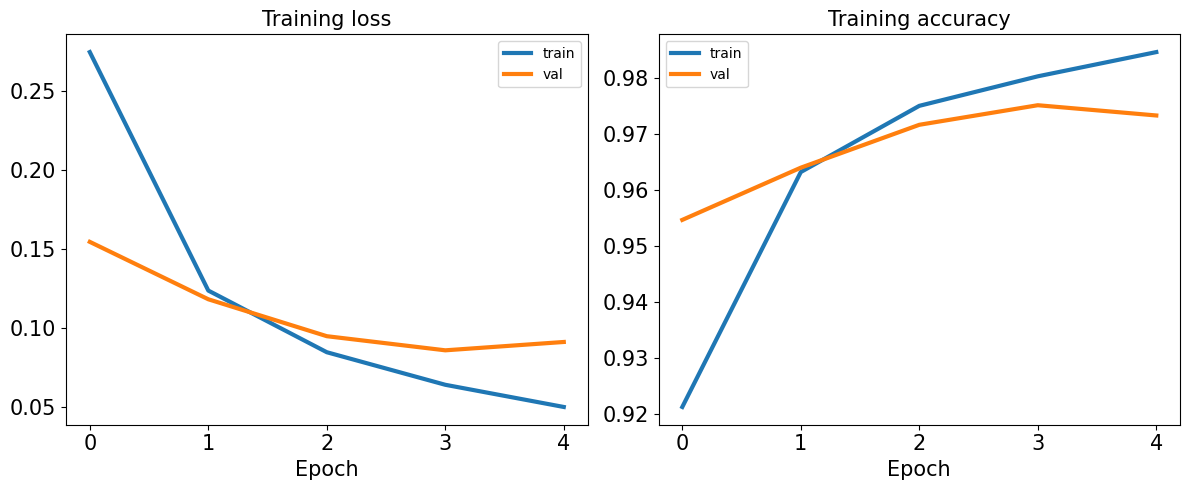

In [14]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.plot(hist['val_loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(['train','val'])

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.plot(hist['val_accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
ax.legend(['train','val'])

#plt.savefig('mnist1.pdf')

plt.show()

In [15]:
test_loss_fn.reset_states()
test_metrics_fn.reset_states()
test_step(X_test, y_test)
print(
    f'Test Loss: {test_loss_fn.result():4.2f}, '
    f'Test Accuracy: {test_metrics_fn.result() * 100:4.2f}')

Test Loss: 0.08, Test Accuracy: 97.61


In [16]:
y_hat = model(X_test)
print(y_hat.shape)
print(y_hat.numpy()[:2])

(10000, 10)
[[ -3.9873822   -6.135191    -0.02649117   0.5421461  -11.5769
   -4.5705833  -16.781677    12.655904    -3.2343109   -2.597616  ]
 [ -5.5328465    6.3625574   13.852592     4.0079083  -17.577782
   -0.9629222   -3.1891186  -14.702382    -0.5102453  -20.203775  ]]
